In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.utils import np_utils
#from keras.optimizers import SGD
from itertools import permutations
import numpy as np
import scipy.io
import pandas as pd
import random
import scipy.stats
from sklearn import metrics
from sklearn import svm
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
#load matlab files
Xd=scipy.io.loadmat(r'/Volumes/GoogleDrive/My Drive/2_TeamWork_VisualNeglect/X_all.mat')
y=scipy.io.loadmat(r'/Volumes/GoogleDrive/My Drive/2_TeamWork_VisualNeglect/Y_p.mat')
subjID = scipy.io.loadmat(r'/Volumes/GoogleDrive/My Drive/2_TeamWork_VisualNeglect/ID_Tr.mat')

X=Xd["X_all"]
y=y["Y_p"]
ID = subjID['ID_Tr']

y=np.squeeze(y)

dimX=np.shape(X)
dimy=np.shape(y)

In [4]:
#perform normalisation
normalisedX = scipy.stats.zscore(X, axis=1)

In [5]:
#create a dataframe with experimental data
trajectories_df = pd.DataFrame(normalisedX)
trajectories_df['y'] = y
trajectories_df['ID'] = ID

In [6]:
#get a list of all possible subject IDs
list_ID = [elem[0] for elem in list(ID)]
list_ID = list(set(list_ID))

In [7]:
#split train and test set - create 20 sets
subject_sample_size = len(list_ID)
#random.seed(14)
TTsets = []
for i in range(0, 20):
    p  = 0.8
    how_many_subjects = int(0.8*subject_sample_size)
    train_sample_subj = random.sample(sorted(list_ID), how_many_subjects)
    test_sample_subj =  [subject for subject in list_ID if subject not in train_sample_subj]

    train_df = trajectories_df[trajectories_df['ID'].isin(train_sample_subj)]
    test_df = trajectories_df[trajectories_df['ID'].isin(test_sample_subj)]
    
    #convert to np.arrays
    train_y = np.array(trajectories_df[trajectories_df['ID'].isin(train_sample_subj)]['y'])
    test_y = np.array(trajectories_df[trajectories_df['ID'].isin(test_sample_subj)]['y'])
    
    train_arr = np.array(train_df)[:,:-2]
    test_arr = np.array(test_df)[:,:-2]
    
    TTsets.append([train_arr, train_y, test_arr, test_y])

In [ ]:
#try K-means or SVM - simpler machine learning techniques
#K - means
kmeans_fit = KMeans(
    init = 'random',
    n_clusters = 2,
    n_init = 10,
    max_iter =  300,
    random_state=42
).fit(normalisedX)
#update ground truth labels so they match the classifier labels
labels_trans = np.copy(y)
labels_trans[labels_trans == -1] = 0
#calculate accuracy
metrics.accuracy_score(labels_trans, kmeans_fit.labels_)

In [192]:
accuracies = []
for TTset in TTsets:
    
    #train
    Xtr=TTset[0]
    ytr=TTset[1]
    
    #test
    Xts=TTset[2]
    yts=TTset[3]
    
    #get the dimensionality
    dimXtr=np.shape(Xtr)
    dimytr=np.shape(ytr)
    
    dimXts=np.shape(Xts)
    dimyts=np.shape(yts)
    
    #SVM
    clf = svm.SVC(kernel = 'poly')
    clf.fit(Xtr, ytr)

    labels_svm = clf.predict(Xts)
    
    #calculate accuracy
    accuracies.append(metrics.accuracy_score(yts, labels_svm))
    
print('Mean SVM accuracy:', np.mean(accuracies), 'stdev:', np.std(accuracies) )

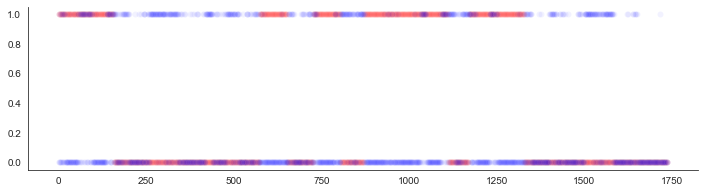

In [11]:
#visualise the outcomes of the kmeans classification
sns.set_style('white')
f, ax = plt.subplots(figsize = (12, 3))

#data for plotting
xplot = pd.DataFrame(labels_trans).index
y1plot = labels_trans
y2plot = kmeans_fit.labels_

#plot the ground truth in red
sns.scatterplot(x = xplot, y = y1plot, color = 'red', alpha = .05)
#plot the classifier outcome in blue
sns.scatterplot(x = xplot, y = y2plot, color = 'blue', alpha = .05)
#pinkish-purple is the overlap
sns.despine()

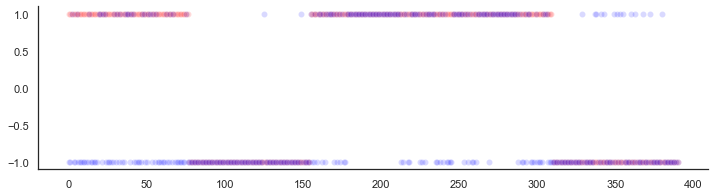

In [205]:
#plot the performance of the last svm classifier
sns.set_style('white')
f, ax = plt.subplots(figsize = (12, 3))

#data to plot
xplot = pd.DataFrame(yts).index
y1plot = yts
y2plot = labels_svm

#plot ground truth in red
sns.scatterplot(x = xplot, y = y1plot, color = 'red', alpha = .05)
#plot classifier in blue
sns.scatterplot(x = xplot, y = y2plot, color = 'blue', alpha = .05)
#pinkish-purple is the overlap
sns.despine()

In [ ]:
# process the data to fit in a keras CNN properly
# input data needs to be (N, C, X, Y) - shaped where
# N - number of samples
# C - number of channels per sample
# (X, Y) - sample size

Xtr_reshaped = Xtr.reshape((dimXtr[0], 1, dimXtr[1], 1))
Xts_reshaped = Xts.reshape((dimXts[0], 1, dimXts[1], 1))

#categorical lebels
ytr_cat = np_utils.to_categorical(ytr)
yts_cat = np_utils.to_categorical(yts)

In [58]:
# define a CNN

cnnbene = Sequential()

#2 conv layers
cnnbene.add(Conv2D(64, (3, 1),activation="relu",input_shape=(1, dimXtr[1], 1),padding="same"))
cnnbene.add(Conv2D(64, (3, 1), activation="relu",padding="same"))

#1max pooling layer
cnnbene.add(MaxPooling2D(pool_size=(2, 1), data_format="channels_first"))

#3conv layers
cnnbene.add(Conv2D(128, (3, 1), activation="relu",padding="same"))
cnnbene.add(Conv2D(128, (3, 1), activation="relu",padding="same"))
cnnbene.add(Conv2D(128, (3, 1), activation="relu",padding="same"))

#1max pooling layer
cnnbene.add(MaxPooling2D(pool_size=(2, 1), data_format="channels_first"))

#3 conv layers
cnnbene.add(Conv2D(256, (3, 1), activation="relu",padding="same"))
cnnbene.add(Conv2D(256, (3, 1), activation="relu",padding="same"))
cnnbene.add(Conv2D(256, (3, 1), activation="relu",padding="same"))

#1 max pooling layer
cnnbene.add(MaxPooling2D(pool_size=(2, 1), data_format="channels_first"))

#2 fully connected layer with dropout regularization 
cnnbene.add(Flatten())
cnnbene.add(Dense(1024, activation="relu"))
cnnbene.add(Dropout(0.5))
cnnbene.add(Dense(2, activation="softmax"))

2022-03-27 11:12:43.441306: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# define optimizer and objective, compile cnn
cnnbene.compile(loss="categorical_crossentropy", optimizer='adagrad', metrics=['accuracy'])

In [ ]:
#sgd = SGD(lr=0.1, decay=1e-6, momentum=1, nesterov=True)
#cnnbene.compile(loss='categorical_crossentropy',
#              optimizer=sgd,
#              metrics=['accuracy'])

In [ ]:
# train
history=cnnbene.fit(Xtr, ytr, validation_data=(Xts,yts), epochs=15,verbose=2, validation_split=0.2)

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# for i in range(12):
#         indx=np.squeeze(np.argwhere(ytspat==i+1))
#         score = cnnbene.evaluate(Xts[indx,:,:,:], yts[indx])
#         print('Mean score', i+1,np.mean(score))

In [ ]:
# for i in range(12):
#     a=len(np.argwhere(ytspat==i+1))
#     print(a)

In [ ]:
#from keras.models import load_model

#model.save('cnnbene')


#cnnbene.save('cnnft.h5')  # creates a HDF5 file 'my_model.h5'



In [ ]:
history.history['accuracy']

